In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, linregress
import os
from datetime import datetime
import sys
sys.path.append('/home/wallacelab/complexity-final/')

import optimization

In [2]:
# Parameters
num_simulations = 1  # Number of simulations to run
task_name = "complexity_prediction"

# Dynamically generate predictor column names '0' through '48'
predictor_columns = [str(i) for i in range(49)]

all_weights = []
spearman_rhos = []

In [3]:
# Run the simulation multiple times
for _ in range(num_simulations):
    # Load your data (ensure these paths are correct)
    df1 = pd.read_csv('/home/wallacelab/complexity-final/ExperimentData/ranking_complexity_scores.csv')
    df2 = pd.read_csv('/home/wallacelab/complexity-final/Embeddings/CLIP-HBA/Dora49/THINGS/filtered_static_embedding.csv')
    
    # Run the bayesian optimization function (make sure it's defined in this notebook or imported)
    best_weights, best_rho = optimization.bayesian_optimization_fit(df1, df2, predictor_columns, task_name=task_name, cross_validate=False)
    all_weights.append(best_weights)
    spearman_rhos.append(best_rho)

Results will be saved in: ./optimization_results_20241127_115722
Starting optimization without cross-validation...
Calculating initial Spearman correlations for each predictor...
Predictor 0: Initial Spearman rho = -0.09165598062508291
Predictor 1: Initial Spearman rho = -0.007021092585820012
Predictor 2: Initial Spearman rho = 0.06786091665153174
Predictor 3: Initial Spearman rho = 0.030825481832264575
Predictor 4: Initial Spearman rho = 0.06524925348587002
Predictor 5: Initial Spearman rho = 0.08925443725535578
Predictor 6: Initial Spearman rho = -0.037616038291219
Predictor 7: Initial Spearman rho = 0.22466415929784087
Predictor 8: Initial Spearman rho = -0.016494758609152494
Predictor 9: Initial Spearman rho = -0.12466070134375548
Predictor 10: Initial Spearman rho = 0.1909072417354905
Predictor 11: Initial Spearman rho = 0.08905605528243407
Predictor 12: Initial Spearman rho = -0.0019264446471606504
Predictor 13: Initial Spearman rho = 0.04121285168525857
Predictor 14: Initial Spe

In [4]:
# Convert weights results to a DataFrame
weights_df = pd.DataFrame(all_weights, columns=predictor_columns)

# Assuming `weights_df` is already calculated from the simulation results
mean_weights = weights_df.mean()
se_weights = weights_df.sem()

# Combine mean and standard error into a new DataFrame
summary_df = pd.DataFrame({
    'Predictor': predictor_columns,
    'Mean Weight': mean_weights,
    'SE Weight': se_weights
})

# Create a unique directory or file name based on a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f'./optimization_results_{timestamp}'
os.makedirs(output_dir, exist_ok=True)

# Save the summary DataFrame as a CSV in the new directory
summary_csv_path = os.path.join(output_dir, 'weights_summary.csv')
summary_df.to_csv(summary_csv_path, index=False)

print(f"Summary of weights saved in: {summary_csv_path}")

Summary of weights saved in: ./optimization_results_20241127_122525/weights_summary.csv


/home/wallacelab/miniconda/envs/complexity_experiment/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/wallacelab/miniconda/envs/complexity_experiment/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


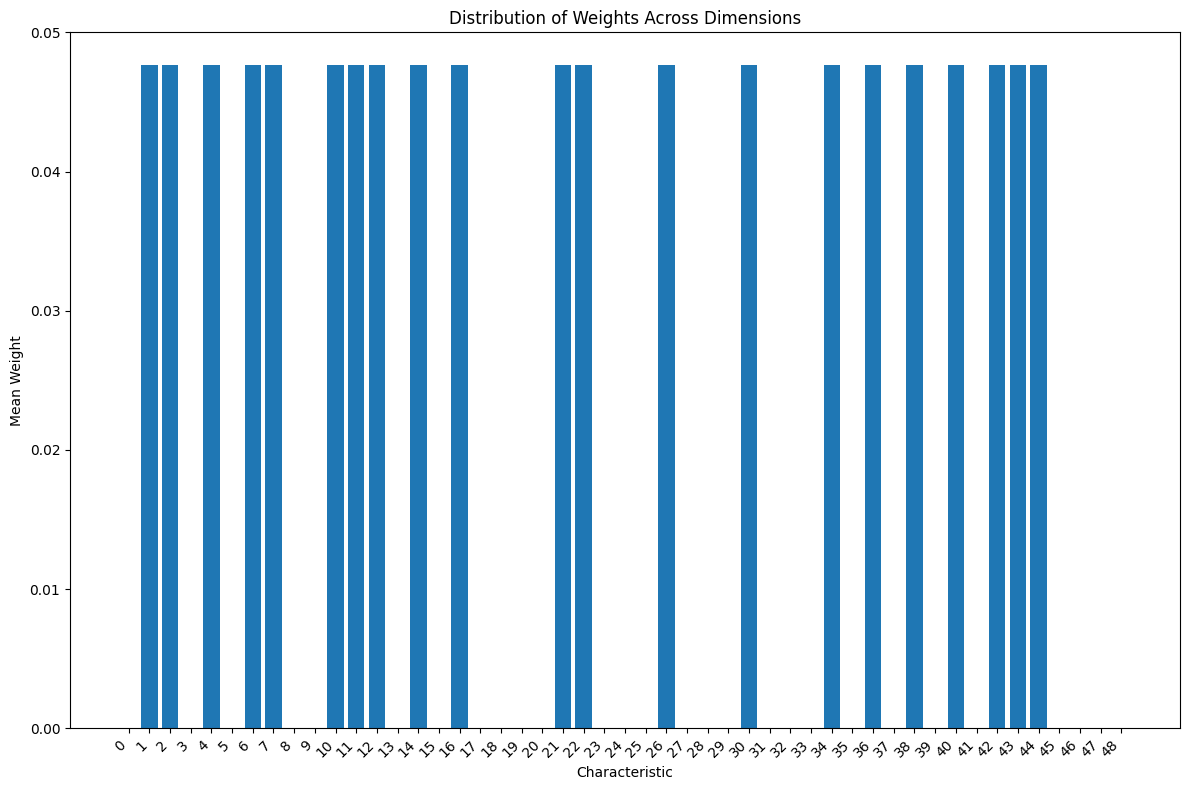

In [5]:
# Plot bar chart with error bars for each characteristic
plt.figure(figsize=(12, 8))
plt.bar(mean_weights.index, mean_weights, yerr=se_weights, capsize=5)
plt.xlabel("Characteristic")
plt.ylabel("Mean Weight")
plt.title("Distribution of Weights Across Dimensions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [6]:
# Find the best (highest) Spearman rho and corresponding weights
best_rho_index = np.argmax(spearman_rhos)
best_rho = spearman_rhos[best_rho_index]
best_weights = all_weights[best_rho_index]

# Calculate predictions for each image using the best weights
# Assuming `df2` contains predictor columns and `df1` contains the actual values
df1 = pd.read_csv('/home/wallacelab/complexity-final/ExperimentData/ranking_complexity_scores.csv')
df2 = pd.read_csv('/home/wallacelab/complexity-final/Embeddings/CLIP-HBA/Dora49/THINGS/filtered_static_embedding.csv')

# Ensure that df1 and df2 are aligned by merging on 'image' column if necessary
if 'image' in df1.columns and 'image' in df2.columns:
    combined_df = pd.merge(df1, df2, on='image')
    y_true = combined_df['Normalized Average'].values
    X = combined_df[predictor_columns].values
else:
    y_true = df1['Normalized Average'].values
    X = df2[predictor_columns].values

# Get predicted values by multiplying X by best weights
y_pred = X @ best_weights

# Calculate the line of best fit for predicted vs. actual
slope, intercept, _, _, _ = linregress(y_pred, y_true)  # Predicted (x) vs. Actual (y)
line_x = np.linspace(y_pred.min(), y_pred.max(), 100)  # Restrict line_x to the range of predicted values
line_y = slope * line_x + intercept  # Compute corresponding y values using the regression equation

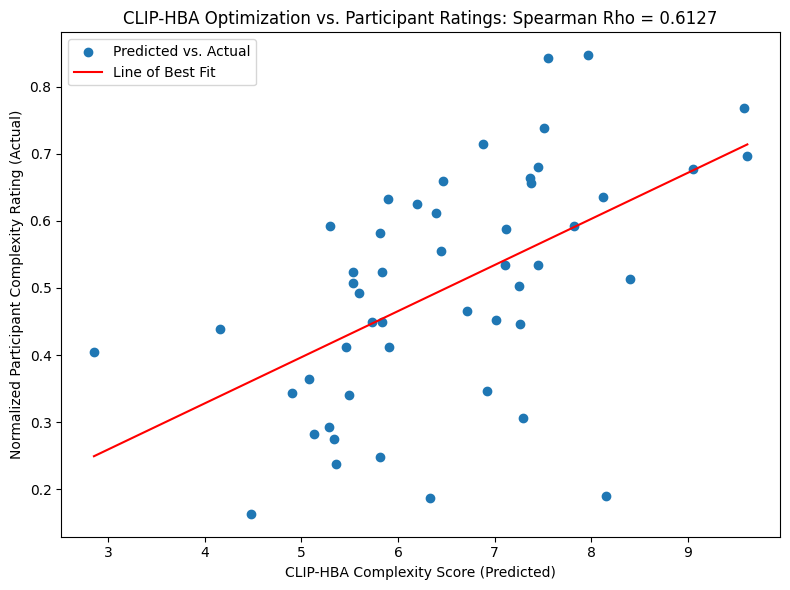

In [7]:
# Plot the scatter plot and line of best fit
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_true, label="Predicted vs. Actual")  # Predicted on x, Actual on y
plt.plot(line_x, line_y, color="red", label="Line of Best Fit")  # Best-fit line for predicted vs. actual
plt.xlabel("CLIP-HBA Complexity Score (Predicted)")
plt.ylabel("Normalized Participant Complexity Rating (Actual)")
plt.title(f"CLIP-HBA Optimization vs. Participant Ratings: Spearman Rho = {best_rho:.4f}")
plt.legend()
plt.tight_layout()
plt.show()